In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

In [2]:
from datasets.density_datasets import Datasets as DensityDatasets
import numpy as np

X, l = DensityDatasets.aggregation.standardized_data_cached

In [3]:
from src.Cluster.DPC.cluster import DensityPeakCluster
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN

l_dpc = DensityPeakCluster(anormal=False).fit(X).labels_
l_hdbscan = HDBSCAN().fit(X).labels_

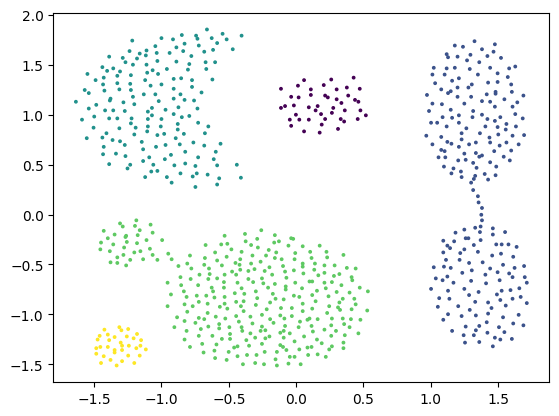

In [4]:
import matplotlib.pyplot as plt

ax = plt.scatter(X[:, 0], X[:, 1], s=3, c=l_hdbscan)
plt.show()

In [6]:
from src.Evaluation import disco_score

disco_score(X, l), disco_score(X, l_dpc), disco_score(X, l_hdbscan)

(0.3056510576364597, 0.5138099180630531, 0.669704899865715)

In [344]:
from src.Evaluation.dcdistances.dctree import DCTree

dctree = DCTree(X, min_points=5, min_points_mr=5)

k = len(set(l))
k = 2

eps = dctree.get_eps_for_k(k)
l_dbscan = DBSCAN(eps).fit(X).labels_
l_kcenter = dctree.get_k_center(k)
print(set(l_dbscan), set(l_kcenter))

In [342]:
from sklearn.metrics import adjusted_rand_score as ARI, normalized_mutual_info_score as NMI

ARI(l_dbscan, l_kcenter), NMI(l_dbscan, l_kcenter)

(1.0, 1.0)

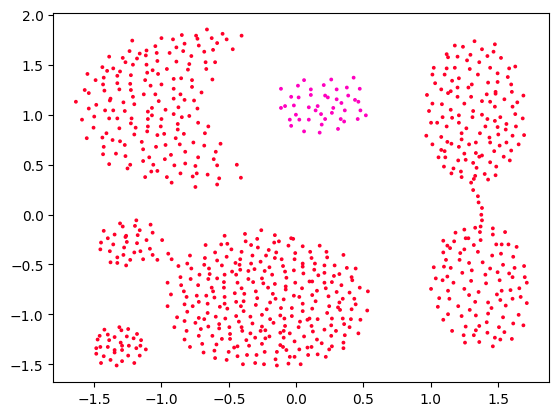

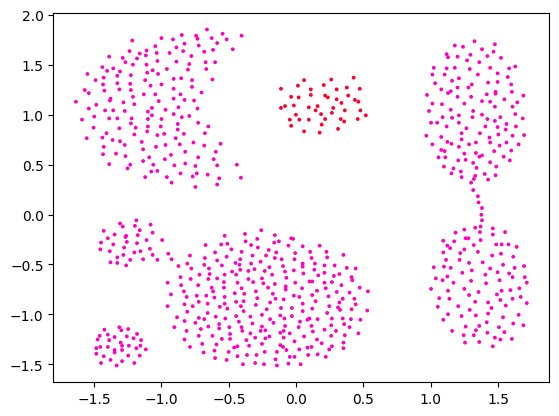

In [343]:
import matplotlib.pyplot as plt

ax = plt.scatter(X[:, 0], X[:, 1], s=3, c=l_dbscan, cmap="gist_rainbow")
plt.show()

ax = plt.scatter(X[:, 0], X[:, 1], s=3, c=l_kcenter, cmap="gist_rainbow")
plt.show()

In [356]:
from src.Evaluation.dcdistances.dctree import DCTree
from src.utils.cluster_algorithms import optimal_k_dbscan

l_ = optimal_k_dbscan(X, l)

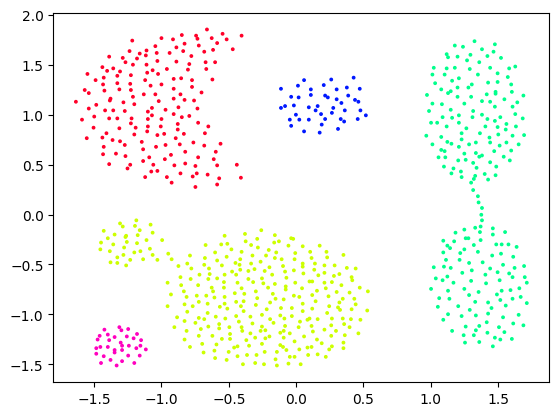

In [357]:
import matplotlib.pyplot as plt

ax = plt.scatter(X[:, 0], X[:, 1], s=3, c=l_, cmap="gist_rainbow")
plt.show()